# Digital Deception Detection: An ML Solution

# 1. Introduction

This project aims to develop a real-time machine learning model for detecting phishing websites based on URL structure and website metadata. By leveraging a range of features extracted from hyperlinks, domain properties, and web content indicators, our model helps security systems and web platforms proactively classify websites as either phishing or legitimate. This approach is designed to strengthen user protection against cyber threats by identifying malicious sites before users interact with them.

The *Web Page Phishing Detection Dataset*$\text{}^{1}$ consists of 11,430 labeled web URLs collected from the Kaggle repository and introduced in the study by Hannousse & Yahiouche (2021). Each instance contains 87 features derived from both the structure of the URL and the behavior or layout of the website itself. These attributes include syntactic patterns, domain reputation signals, and HTML/JavaScript behaviors commonly associated with phishing attempts.

# 2. Library Imports 

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import (classification_report, confusion_matrix, 
                           roc_auc_score, roc_curve, accuracy_score, 
                           precision_score, recall_score, f1_score)
from sklearn.feature_selection import SelectKBest, f_classif, RFE
import xgboost as xgb
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

## Functions

In [7]:
def plot_features(df, features, title):
    # set the number of columns per row
    n_cols = 4
    n_rows = (len(features) + n_cols - 1) // n_cols  # auto-adjust rows
    
    # create subplots
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20, n_rows * 3))
    axes = axes.flatten()
    
    # plot histograms using seaborn
    for i, feature in enumerate(features):
        sns.histplot(data=df, x=feature, ax=axes[i], bins=20, kde=False, edgecolor='black')
        axes[i].set_title(feature)
        axes[i].set_xlabel("value")
        axes[i].set_ylabel("frequency")
    
    # remove unused axes
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    # set overall title and layout
    fig.suptitle(title)
    plt.tight_layout()
    plt.show()


In [8]:
def plot_feat_cor(df, features, title):
    # dynamic rows/columns
    n_cols = 4
    n_rows = (len(features) + n_cols - 1) // n_cols
    
    # create subplots
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(14, n_rows * 4))
    axes = axes.flatten()
    
    # plot boxplots for each selected feature
    for i, feature in enumerate(features):
        sns.boxplot(data=df, x='status', y=feature, ax=axes[i])
        axes[i].set_title(feature)
        axes[i].set_ylabel(feature)
    
    # remove the unused subplot if needed
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()

In [9]:
def plot_feats_box(df, n_feats, c_feats, target, title):
    import matplotlib.pyplot as plt
    import seaborn as sns

    total_plots = len(n_feats) + len(c_feats)
    n_cols = 4
    n_rows = (total_plots + n_cols - 1) // n_cols

    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(16, n_rows * 4))
    axes = axes.flatten()

    idx = 0

    # Numeric features: target on x-axis, numeric on y-axis
    for feat in n_feats:
        sns.boxplot(data=df, x=target, y=feat, ax=axes[idx])
        axes[idx].set_title(f'{feat} vs {target}')
        axes[idx].set_xlabel(target)
        axes[idx].set_ylabel(feat)
        idx += 1

    # Categorical features: category on x-axis, numeric target on y-axis
    for feat in c_feats:
        sns.boxplot(data=df, x=feat, y=target, ax=axes[idx])
        axes[idx].set_title(f'{target} vs {feat}')
        axes[idx].set_xlabel(feat)
        axes[idx].set_ylabel(target)
        axes[idx].tick_params(axis='x', rotation=45)
        idx += 1

    # Remove unused axes
    for j in range(idx, len(axes)):
        fig.delaxes(axes[j])

    fig.suptitle(title, fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


# 3. Data Loading and Initial Overview
In this section, we load the dataset and perform initial data exploration.

In [11]:
df_raw = pd.read_csv("data/dataset_phishing.csv")
df_raw.head() # check the first few rows of our data
df_raw.shape

(11430, 89)

In [12]:
# get shape of data set, data types and non-null count
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11430 entries, 0 to 11429
Data columns (total 89 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   url                         11430 non-null  object 
 1   length_url                  11430 non-null  int64  
 2   length_hostname             11430 non-null  int64  
 3   ip                          11430 non-null  int64  
 4   nb_dots                     11430 non-null  int64  
 5   nb_hyphens                  11430 non-null  int64  
 6   nb_at                       11430 non-null  int64  
 7   nb_qm                       11430 non-null  int64  
 8   nb_and                      11430 non-null  int64  
 9   nb_or                       11430 non-null  int64  
 10  nb_eq                       11430 non-null  int64  
 11  nb_underscore               11430 non-null  int64  
 12  nb_tilde                    11430 non-null  int64  
 13  nb_percent                  114

# 4. Exploratory Data Analysis (EDA)
In this section, we analyze the data statistical analysis and visualizations to uncover trends and relationships between variables. Given the large number of features (80+), we organize them into categories based on the type and origin of the information they represent

### URL Structure Features
- `length_url`: Total number of characters in the URL.
- `length_hostname`: Length of the domain/host portion.
- `ip`: 1 if IP address is used in URL, 0 if domain name.
- `nb_dots`: Number of dots (`.`) in the URL.
- `nb_hyphens`: Number of hyphens (`-`) in the URL.
- `nb_at`: Number of at symbols (`@`) in the URL.
- `nb_qm`: Number of question marks (`?`) in the URL.
- `nb_and`: Number of ampersands (`&`) in the URL.
- `nb_or`: Number of pipe symbols (`|`) in the URL.
- `nb_eq`: Number of equal signs (`=`) in the URL.
- `nb_underscore`: Number of underscores (`_`).
- `nb_tilde`: Number of tildes (`~`).
- `nb_percent`: Number of percent signs (`%`).
- `nb_slash`: Number of slashes (`/`).
- `nb_star`: Number of asterisks (`*`).
- `nb_colon`: Number of colons (`:`).
- `nb_comma`: Number of commas (`,`).
- `nb_semicolumn`: Number of semicolons (`;`).
- `nb_dollar`: Number of dollar signs (`$`).
- `nb_space`: Number of spaces.
- `nb_www`: Occurrences of “www” in the URL.
- `nb_com`: Occurrences of “.com” in the URL.
- `nb_dslash`: Double slashes (`//`) beyond the protocol.
- `http_in_path`: Occurrences of “http” in the URL
- `https_token`: 1 if “https” is used deceptively in the path or subdomain.

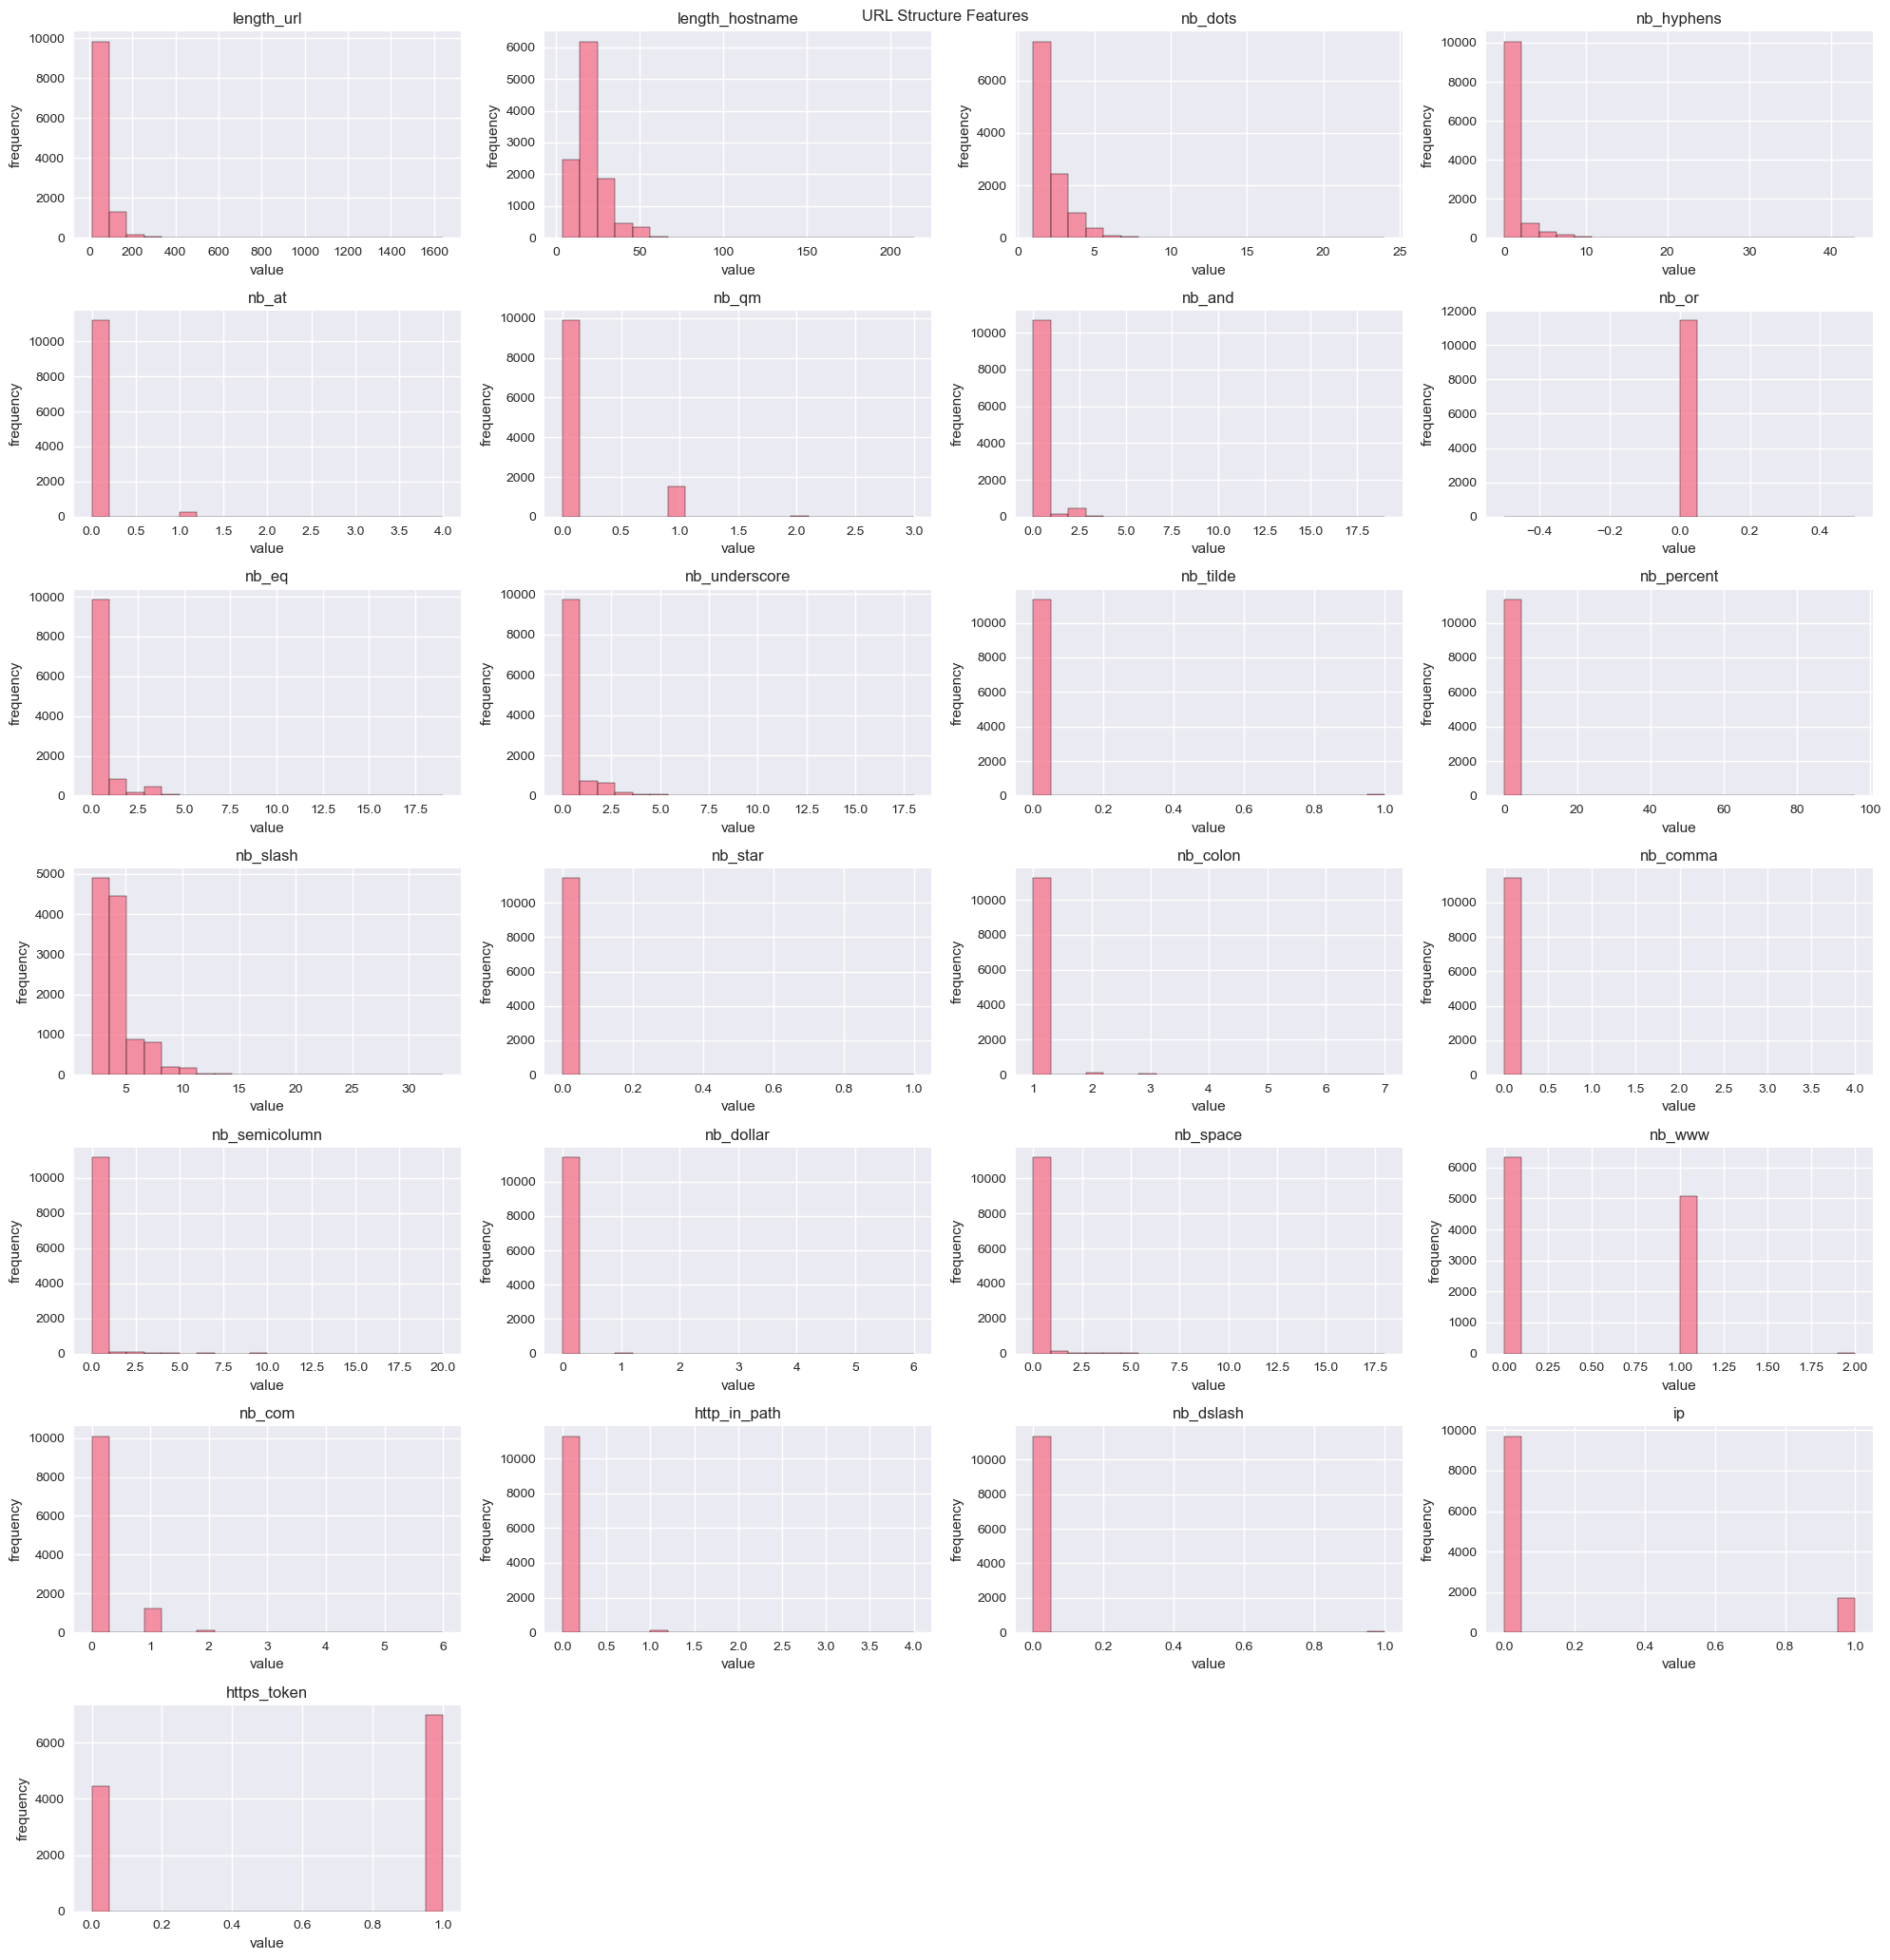

In [15]:
# selected feature 
url_structure_features = [
    'length_url',
    'length_hostname',
    'nb_dots',
    'nb_hyphens',
    'nb_at',
    'nb_qm',
    'nb_and',
    'nb_or',
    'nb_eq',
    'nb_underscore',
    'nb_tilde',
    'nb_percent',
    'nb_slash',
    'nb_star',
    'nb_colon',
    'nb_comma',
    'nb_semicolumn',
    'nb_dollar',
    'nb_space',
    'nb_www',
    'nb_com',
    'http_in_path',
    'nb_dslash',
    'ip',
    'https_token'
]

# plot features
plot_features(df_raw, url_structure_features, "URL Structure Features")

### Character Ratio Features
- `ratio_digits_url`: Ratio of numeric characters in URL.
- `ratio_digits_host`: Ratio of numeric characters in the domain name.

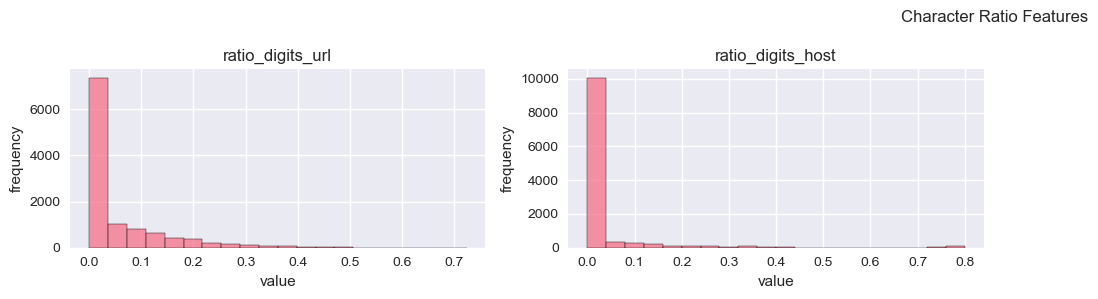

In [17]:
character_ratio_features = [
    'ratio_digits_url',
    'ratio_digits_host'
]

plot_features(df_raw, character_ratio_features, "Character Ratio Features")

### Domain Features
- `punycode`: 1 if domain uses punycode (non-ASCII domain).
- `port`: Port number used.
- `tld_in_path`: 1 if top-level domain appears in the path.
- `tld_in_subdomain`: 1 if TLD is in the subdomain.
- `abnormal_subdomain`: 1 if subdomain appears unusual or suspicious.
- `nb_subdomains`: Number of subdomains in the URL.
- `prefix_suffix`: 1 if a hyphen separates parts of the domain.
- `random_domain`: 1 if domain is likely randomly generated.
- `shortening_service`: 1 if a URL shortener is used.

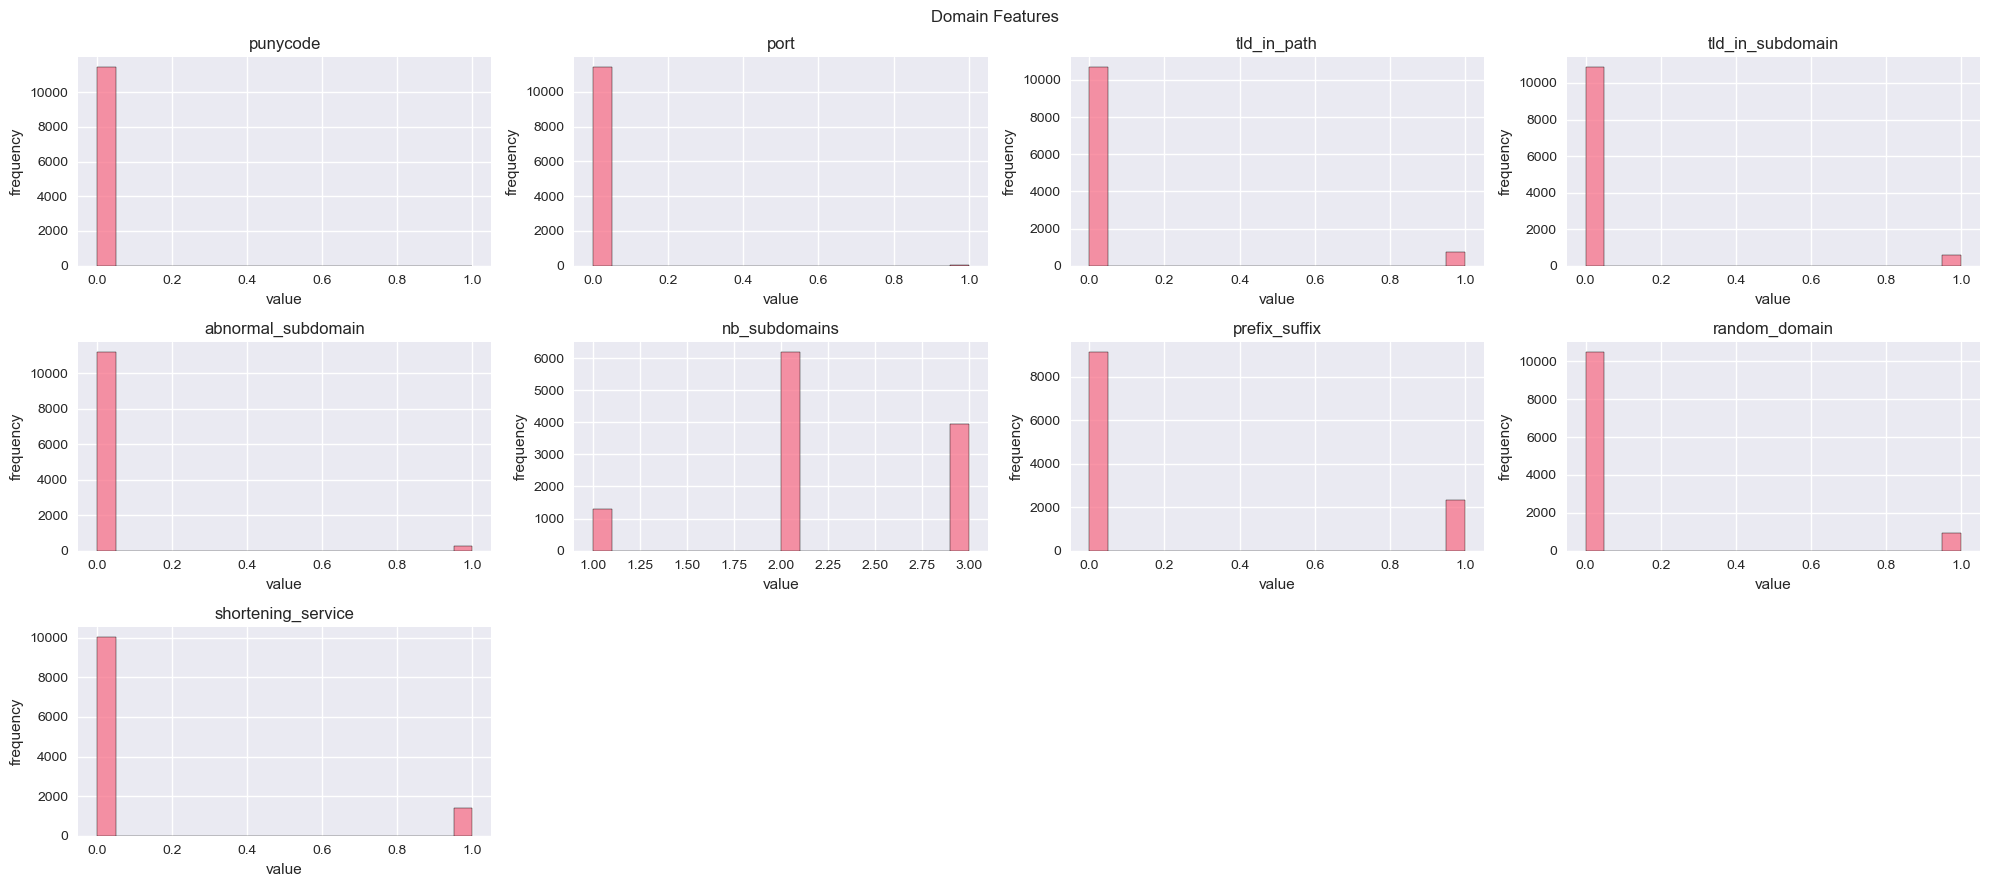

In [19]:
domain_features = [
    'punycode',
    'port',
    'tld_in_path',
    'tld_in_subdomain',
    'abnormal_subdomain',
    'nb_subdomains',
    'prefix_suffix',
    'random_domain',
    'shortening_service'
]

plot_features(df_raw, domain_features, "Domain Features")

### Text Analysis Features
- `length_words_raw`: Total character length of all words in the URL.
- `char_repeat`: Repeated characters (e.g., “aaaa”).
- `shortest_words_raw`: Length of the shortest word in the URL.
- `shortest_word_host`: Length of the shortest word in the hostname.
- `shortest_word_path`: Length of the shortest word in the path.
- `longest_words_raw`: Length of the longest word in the URL.
- `longest_word_host`: Longest word in the host.
- `longest_word_path`: Longest word in the path.
- `avg_words_raw`: Average word length in the full URL.
- `avg_word_host`: Average word length in the host.
- `avg_word_path`: Average word length in the path.

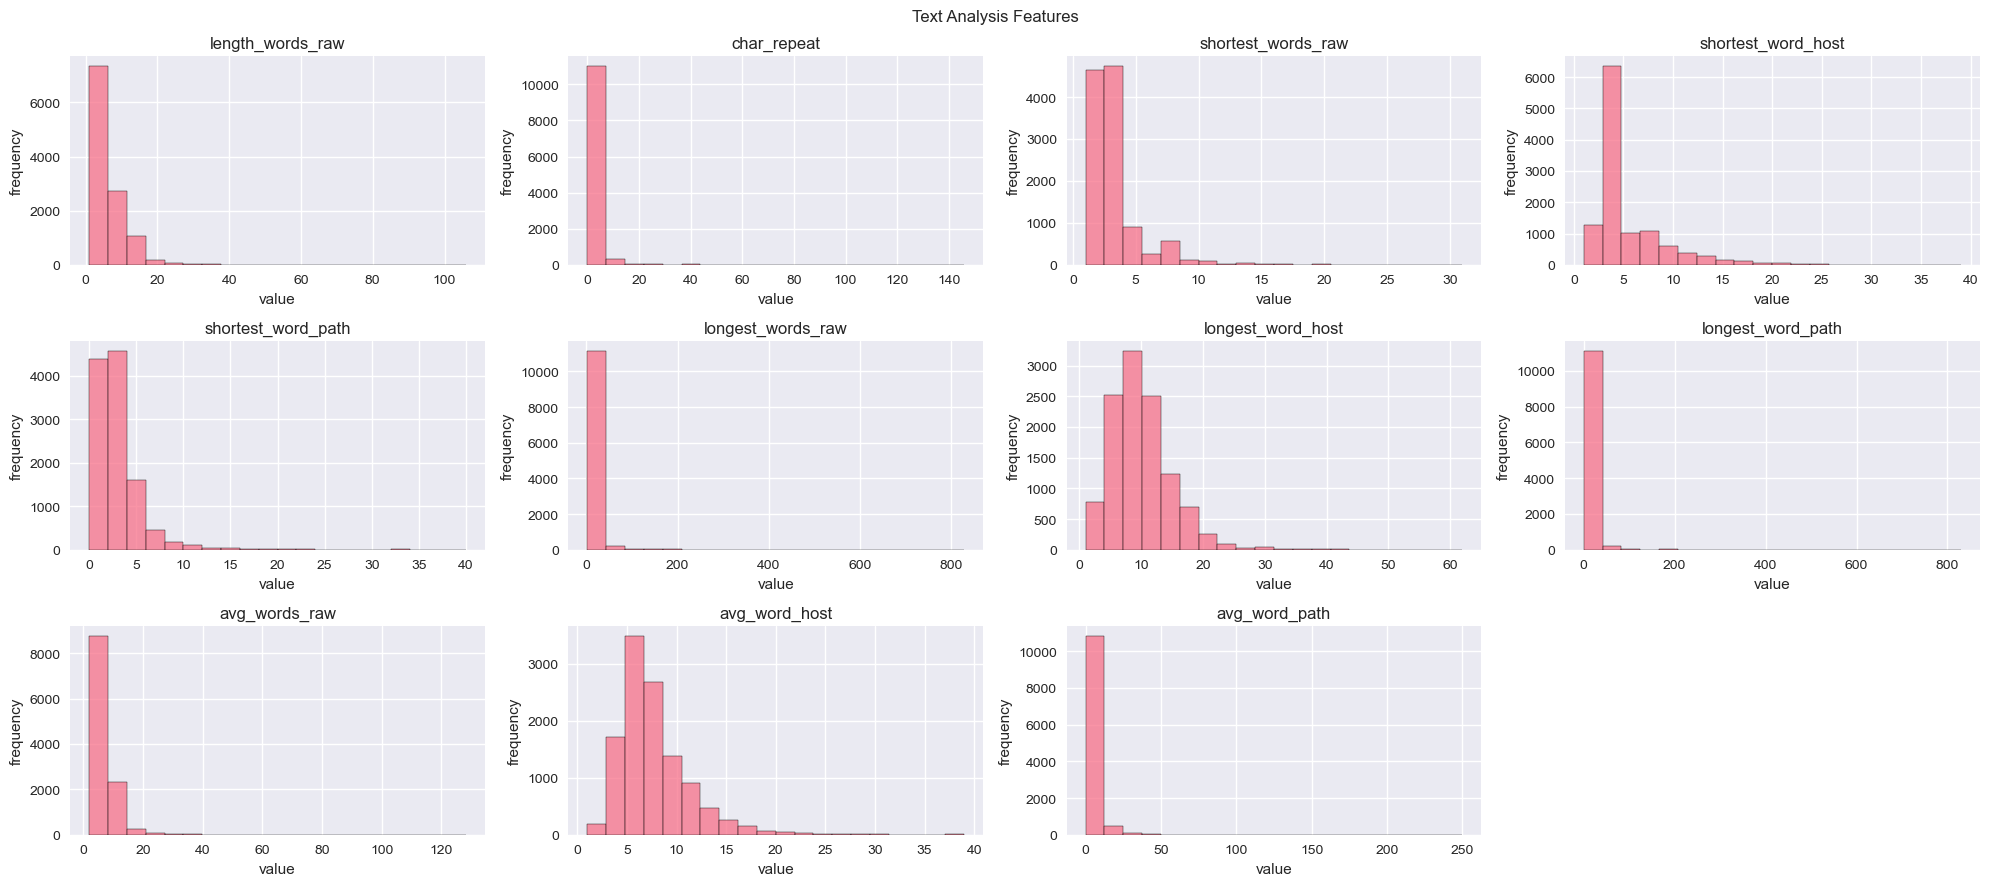

In [21]:
text_analysis_features = [
    'length_words_raw',
    'char_repeat',
    'shortest_words_raw',
    'shortest_word_host',
    'shortest_word_path',
    'longest_words_raw',
    'longest_word_host',
    'longest_word_path',
    'avg_words_raw',
    'avg_word_host',
    'avg_word_path'
]

plot_features(df_raw, text_analysis_features, "Text Analysis Features")

### Heuristic Features
- `phish_hints`: Count of phishing-related words in the URL.
- `domain_in_brand`: 1 if domain name is part of a known brand.
- `brand_in_subdomain`: 1 if brand name is in the subdomain.
- `brand_in_path`: 1 if brand name appears in the path.
- `suspecious_tld`: 1 if TLD is commonly used in phishing.
- `statistical_report`: 1 if flagged in threat intelligence sources.

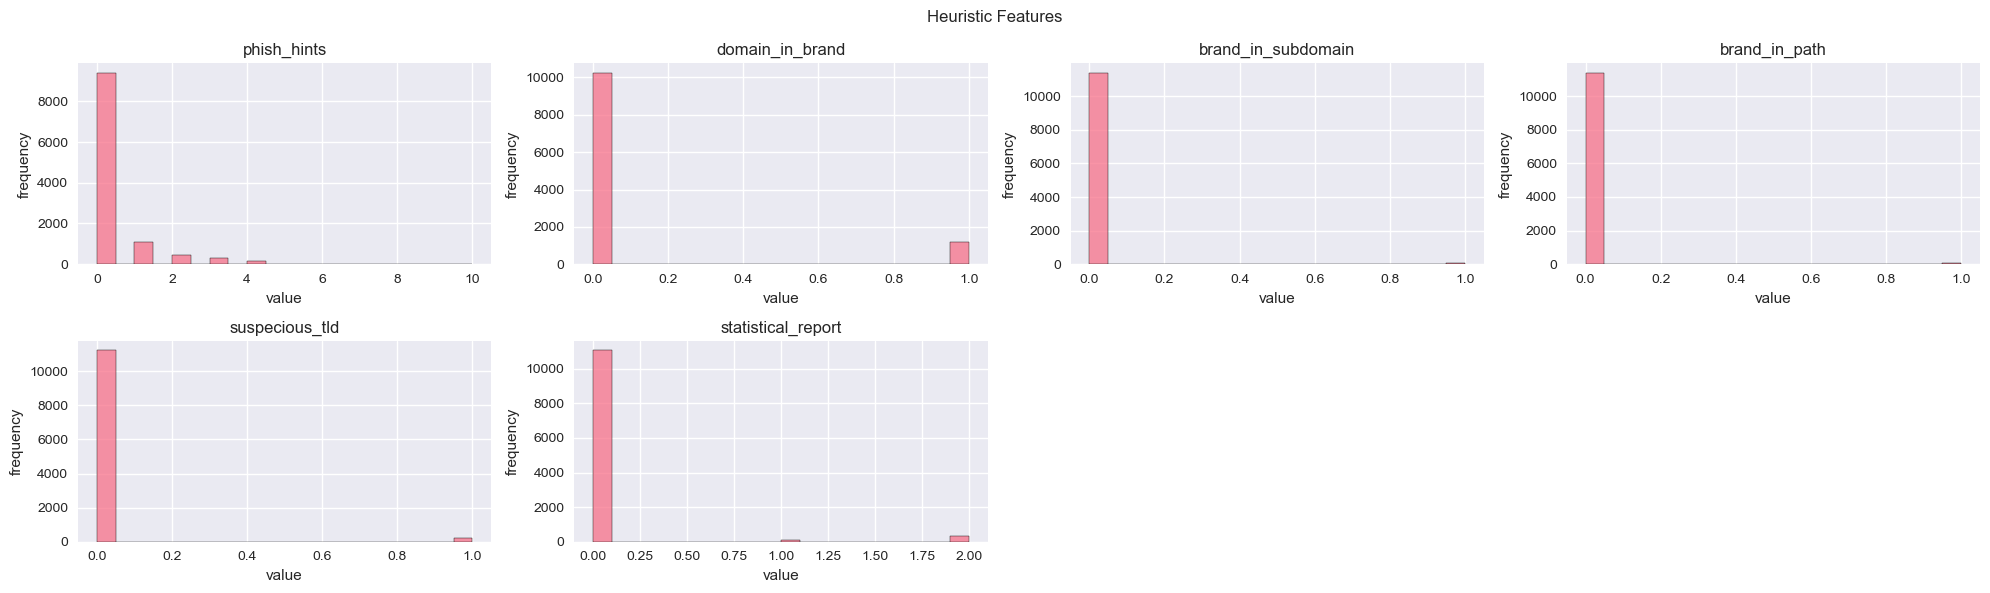

In [23]:
heuristic_features = [
    'phish_hints',
    'domain_in_brand',
    'brand_in_subdomain',
    'brand_in_path',
    'suspecious_tld',
    'statistical_report'
]

plot_features(df_raw, heuristic_features, "Heuristic Features")

### HTML & JavaScript Features
- `nb_hyperlinks`: Number of hyperlinks on the page.
- `ratio_intHyperlinks`: Ratio of internal links.
- `ratio_extHyperlinks`: Ratio of external links.
- `ratio_nullHyperlinks`: Ratio of null/empty links.
- `nb_extCSS`: Number of external CSS files used.
- `ratio_intRedirection`: Ratio of internal redirection links.
- `ratio_extRedirection`: Ratio of external redirection links.
- `ratio_intErrors`: Ratio of broken internal links.
- `ratio_extErrors`: Ratio of broken external links.
- `login_form`: 1 if a login form is detected.
- `external_favicon`: 1 if favicon is loaded from a third-party site.
- `links_in_tags`: Ratio of links embedded in HTML tags.
- `submit_email`: 1 if form submission goes to an email address.
- `ratio_intMedia`: Ratio of internal media content.
- `ratio_extMedia`: Ratio of external media content.
- `sfh`: Abnormal form action (Server Form Handler).
- `iframe`: 1 if page contains iframe elements.
- `popup_window`: 1 if popups are triggered by JavaScript.
- `safe_anchor`: Proportion of anchors with safe labels.
- `onmouseover`: 1 if mouse-over tricks are used.
- `right_clic`: 1 if right-click is disabled.
- `empty_title`: 1 if HTML title is empty.
- `domain_in_title`: 1 if domain name appears in HTML title.

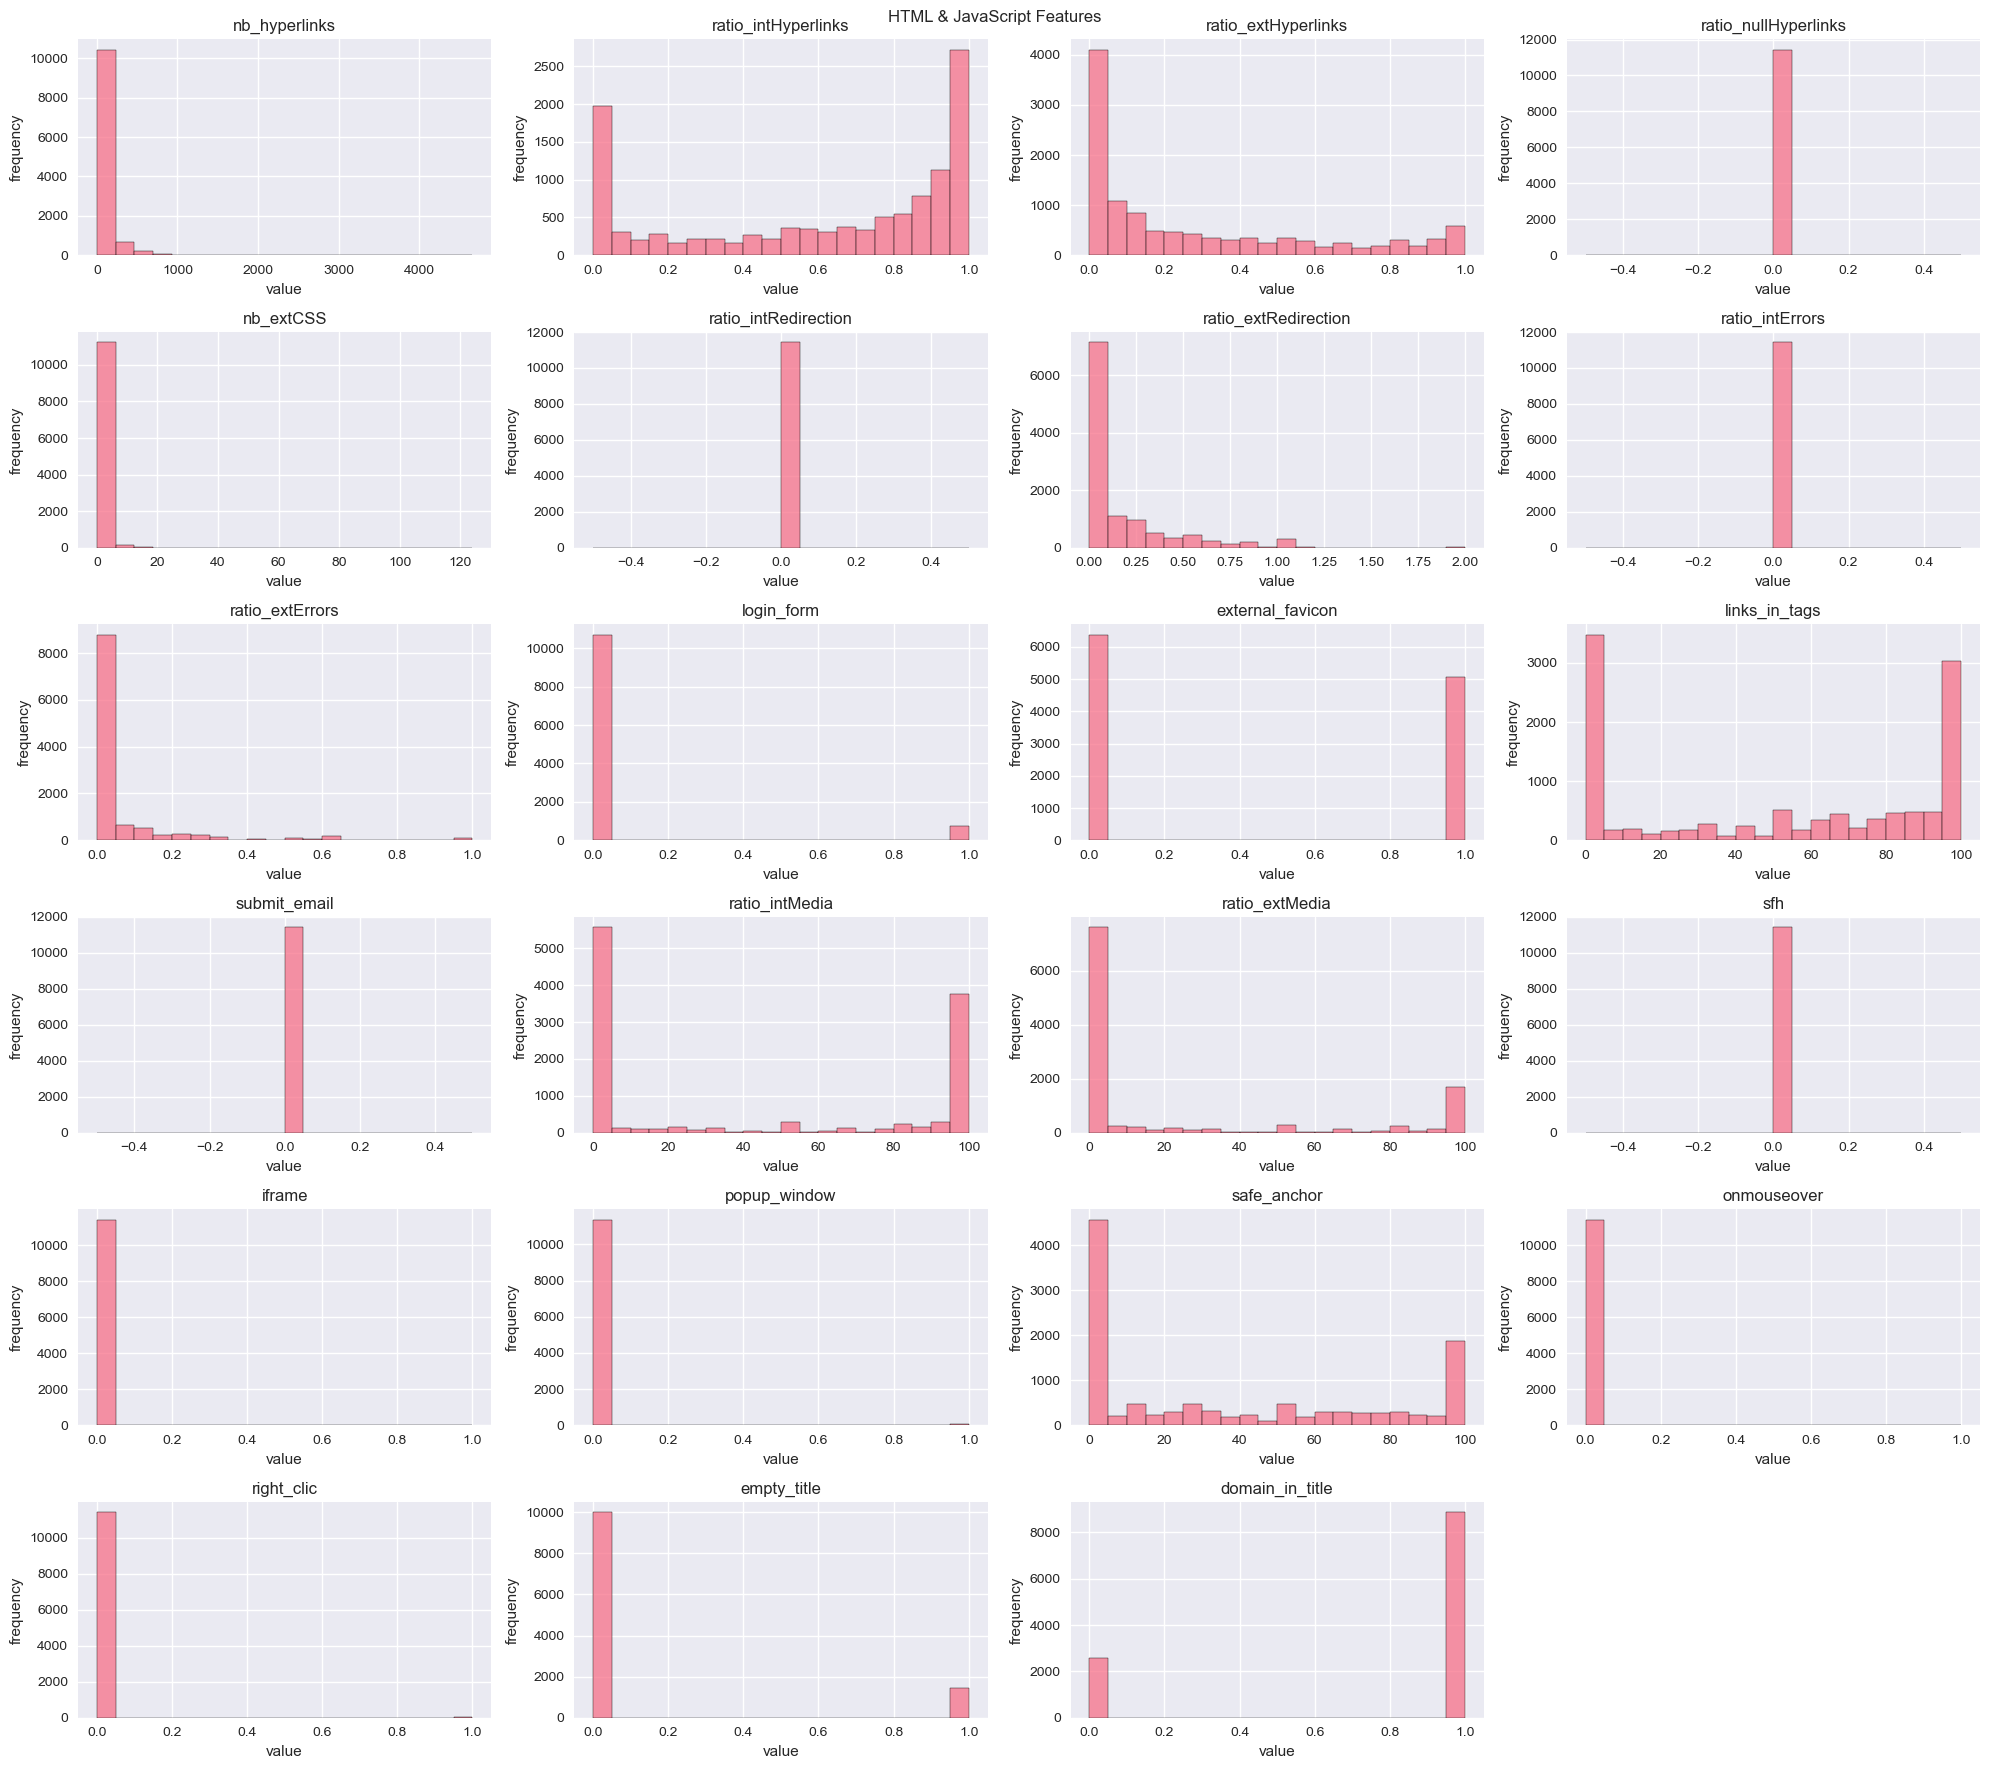

In [25]:
js_features = [
    'nb_hyperlinks',
    'ratio_intHyperlinks',
    'ratio_extHyperlinks',
    'ratio_nullHyperlinks',
    'nb_extCSS',
    'ratio_intRedirection',
    'ratio_extRedirection',
    'ratio_intErrors',
    'ratio_extErrors',
    'login_form',
    'external_favicon',
    'links_in_tags',
    'submit_email',
    'ratio_intMedia',
    'ratio_extMedia',
    'sfh',
    'iframe',
    'popup_window',
    'safe_anchor',
    'onmouseover',
    'right_clic',
    'empty_title',
    'domain_in_title'
]

plot_features(df_raw, js_features, "HTML & JavaScript Features")

### WHOIS Features - derived from domain registration data
- `whois_registered_domain`: 1 if WHOIS data is available for the domain, 0 if not (missing WHOIS is suspicious).
- `domain_registration_length`: Number of days the domain is registered for (longer = more likely to be legitimate).
- `domain_age`: Age of the domain in days (newly registered domains are common in phishing).

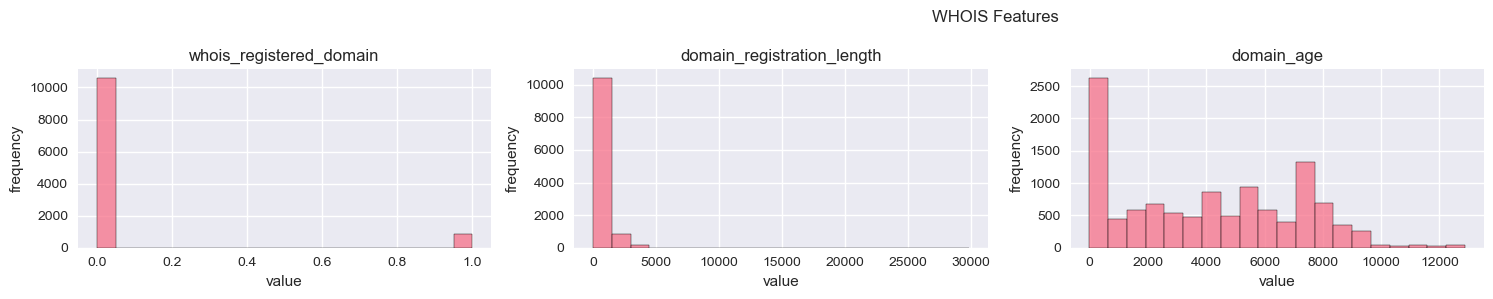

In [27]:
whois_features = [
    'whois_registered_domain',
    'domain_registration_length',
    'domain_age'
]

plot_features(df_raw, whois_features, "WHOIS Features")

### Search Engine Optimization (SEO) Features - online reputation and discoverability of the website
- `web_traffic`: Estimated amount of traffic the website gets (e.g., from Alexa rank); low traffic can be suspicious.
- `dns_record`: 1 if the domain has valid DNS records; 0 if not.
- `google_index`: 1 if the site is indexed by Google, 0 if not (phishing sites often are not).
- `page_rank`: An SEO-based score from 0 to 10; higher scores mean more authoritative/trusted sites.
- `domain_with_copyright`: 1 if the domain has copyright meta information, indicating professionalism or legitimacy.


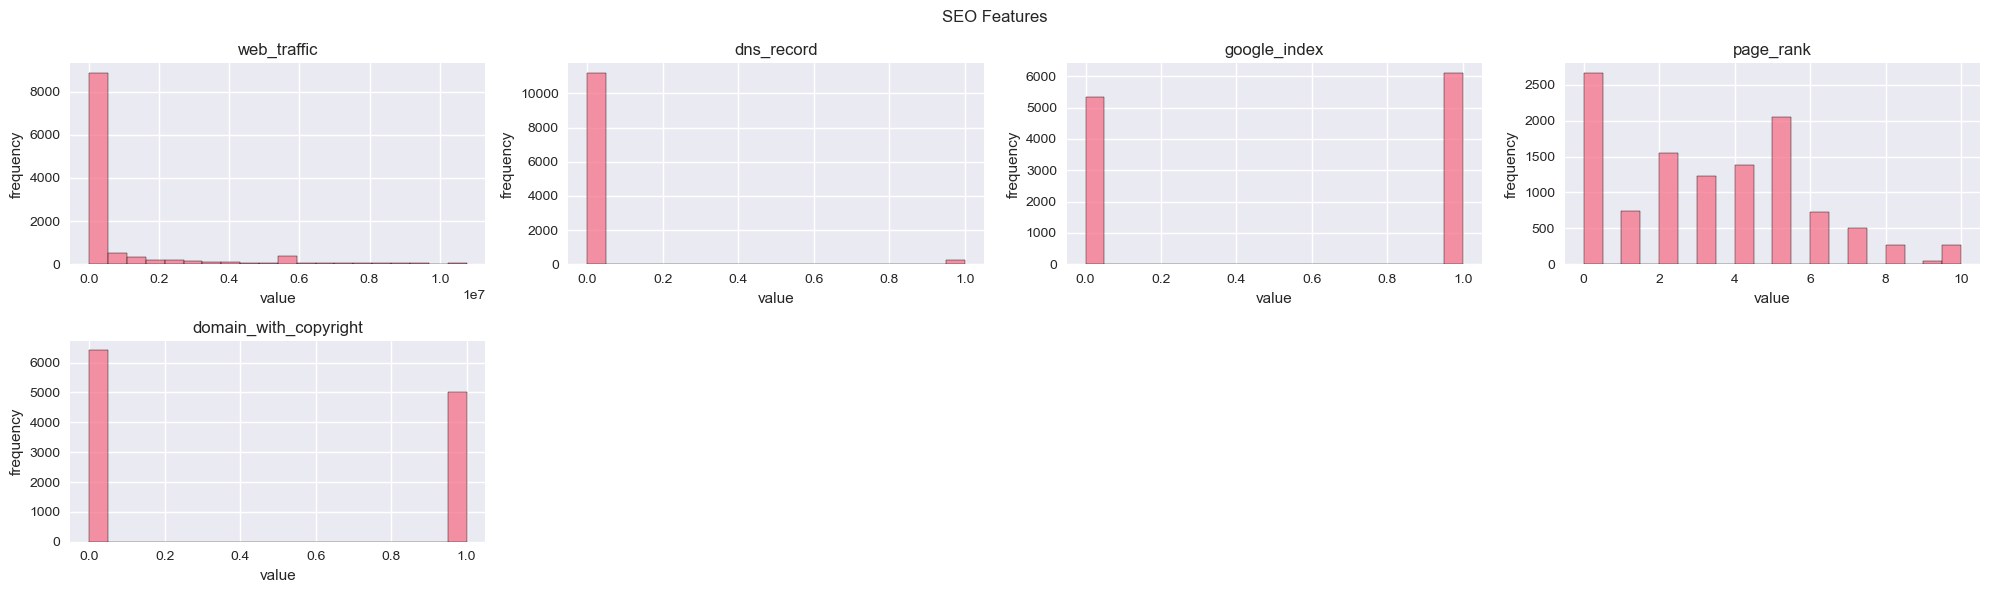

In [29]:
seo_features = [
    'web_traffic',
    'dns_record',
    'google_index',
    'page_rank',
    'domain_with_copyright'
]

plot_features(df_raw, seo_features, "SEO Features")

### Target Variable
- `status`: Classification label — `phishing` or `legitimate`.


Text(0.5, 1.0, 'Class Distribution')

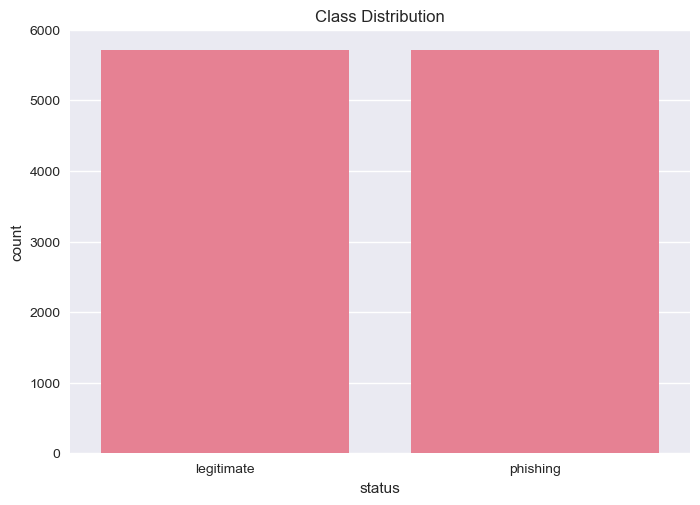

In [31]:
# check target distribution
sns.countplot(x='status', data=df_raw)
plt.title("Class Distribution")

### Correlation Matrix
Identify the top 10 features most strongly correlated with the target variable.

In [33]:
# convert target into numeric
df_raw['status_binary'] = df_raw['status'].apply(lambda x: 1 if x == 'phishing' else 0)

# get correlations with the target variable only
target_corr = df_raw.corr(numeric_only=True)['status_binary'].drop('status_binary')

# get top 50 features most correlated with the target
top50_corr = target_corr.abs().sort_values(ascending=False).head(50)

print("Top 50 Features Most Correlated with Target:\n")
for feature in top50_corr.index:
    print(f"{feature:40s} : {target_corr[feature]:.4f}")


Top 50 Features Most Correlated with Target:

google_index                             : 0.7312
page_rank                                : -0.5111
nb_www                                   : -0.4435
ratio_digits_url                         : 0.3564
domain_in_title                          : 0.3428
nb_hyperlinks                            : -0.3426
phish_hints                              : 0.3354
domain_age                               : -0.3319
ip                                       : 0.3217
nb_qm                                    : 0.2943
length_url                               : 0.2486
ratio_intHyperlinks                      : -0.2440
nb_slash                                 : 0.2423
length_hostname                          : 0.2383
nb_eq                                    : 0.2334
ratio_digits_host                        : 0.2243
shortest_word_host                       : 0.2231
prefix_suffix                            : 0.2147
longest_word_path                        : 0.2127

### Boxplot

Analyze the top 50 features most correlated with the target variable to understand their relationship and distribution across classes.

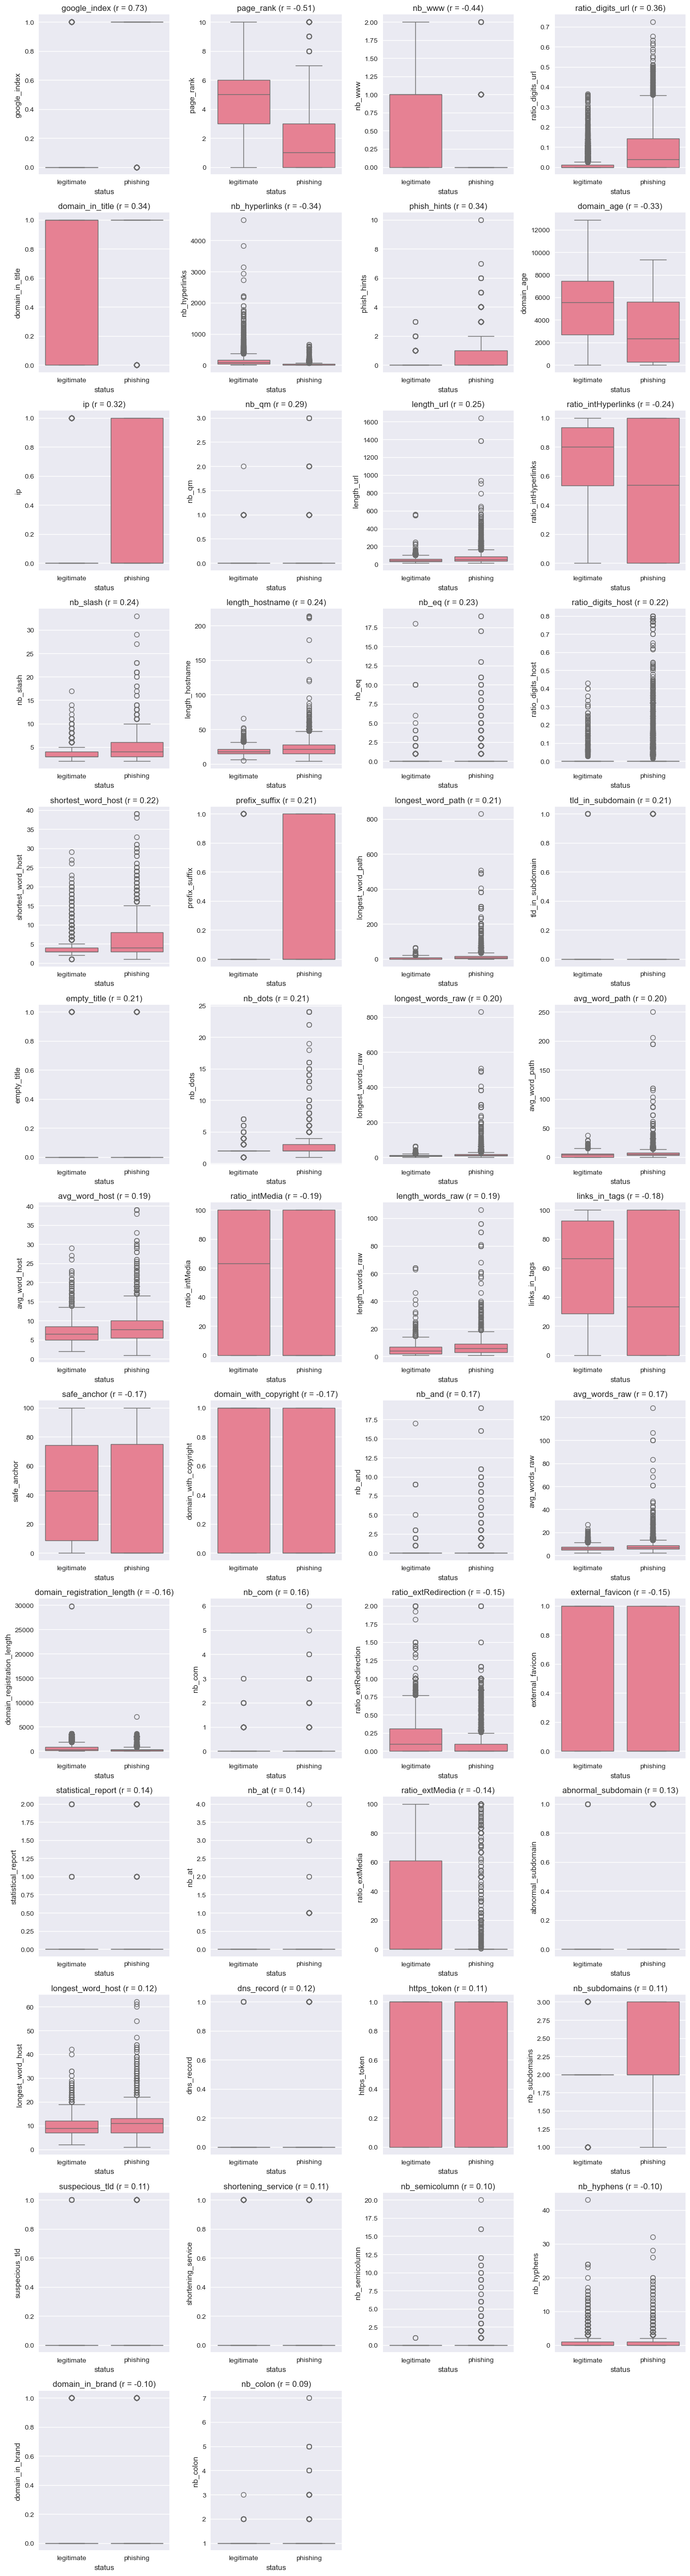

In [35]:
# dynamic rows/columns
n_cols = 4
n_rows = (len(top50_corr) + n_cols - 1) // n_cols

# dreate subplots
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(14, n_rows * 4))
axes = axes.flatten()

# boxplots for each selected feature
for i, feature in enumerate(top50_corr.index):
    sns.boxplot(data=df_raw, x='status', y=feature, ax=axes[i])
    axes[i].set_title(f"{feature} (r = {target_corr[feature]:.2f})")
    axes[i].set_xlabel("status")
    axes[i].set_ylabel(feature)

# remove the unused subplots if any
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# 5. Machine Learning (ML) Models  
In this section, we train and evaluate various traditional ML models to predict the target variables (status: phishing or legitimate).  

### Steps:  
- **Data Preparation:** Identifying target variables.  
- **Data Splitting:** Dividing the data into training (60%), validation (20%) and test (20%) sets.  
- **Model Training:** Training several traditional ML. 
- **Model Evaluation:** Models are tested against the validation dataset, comparing results using metrics such as **MSE, RMSE, and R-square scores**.
- **Model Fine-tuning:** The best model is selected. The model is further fine-tuned using techniques such as `GridSearchCV`.
- **Model Test:** The final model is evaluated on the test dataset to measure real-world performance.

### Data Preparation

In [38]:
top_50_features = top50_corr.index.tolist()

X = df_raw[top_50_features]
y = df_raw['status_binary']

### Data Splitting
- 60% training
- 20% validation
- 20% testing

In [40]:
# split the data 60/20/20
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp)

print(f"Data split completed:")
print(f"Training: {X_train.shape[0]} samples")
print(f"Validation: {X_val.shape[0]} samples") 
print(f"Test: {X_test.shape[0]} samples")

Data split completed:
Training: 6858 samples
Validation: 2286 samples
Test: 2286 samples


### Model Training (XGBoost)

In [42]:
# Baseline XGBoost Model
print("\nBaseline XGBoost Training")

baseline_model = XGBClassifier(
    objective='binary:logistic',
    random_state=42,
    eval_metric='logloss',
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    early_stopping_rounds=10,
    verbose=False
)

print("Training baseline XGBoost model...")
baseline_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=False
)


Baseline XGBoost Training
Training baseline XGBoost model...


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

### Model Evaluation (XGBoost)

In [44]:
# Evaluate baseline model
y_val_pred_baseline = baseline_model.predict(X_val)
y_val_pred_proba_baseline = baseline_model.predict_proba(X_val)[:, 1]

baseline_accuracy = accuracy_score(y_val, y_val_pred_baseline)
baseline_precision = precision_score(y_val, y_val_pred_baseline)
baseline_recall = recall_score(y_val, y_val_pred_baseline)
baseline_f1 = f1_score(y_val, y_val_pred_baseline)
baseline_auc = roc_auc_score(y_val, y_val_pred_proba_baseline)

print(f"\nBaseline XGBoost Results:")
print(f"Accuracy:  {baseline_accuracy:.4f}")
print(f"Precision: {baseline_precision:.4f}")
print(f"Recall:    {baseline_recall:.4f}")
print(f"F1-Score:  {baseline_f1:.4f}")
print(f"AUC:       {baseline_auc:.4f}")


Baseline XGBoost Results:
Accuracy:  0.9624
Precision: 0.9616
Recall:    0.9633
F1-Score:  0.9624
AUC:       0.9933


### Model Training (Random Forest)

In [46]:
print("\nRandom Forest Training")

rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)

print("Training Random Forest model...")
rf_model.fit(X_train, y_train)



Random Forest Training
Training Random Forest model...


RandomForestClassifier(max_depth=10, n_jobs=-1, random_state=42)

### Model Evaluation (Random Forest)

In [48]:
y_val_pred_rf = rf_model.predict(X_val)
y_val_pred_proba_rf = rf_model.predict_proba(X_val)[:, 1]

rf_accuracy = accuracy_score(y_val, y_val_pred_rf)
rf_precision = precision_score(y_val, y_val_pred_rf)
rf_recall = recall_score(y_val, y_val_pred_rf)
rf_f1 = f1_score(y_val, y_val_pred_rf)
rf_auc = roc_auc_score(y_val, y_val_pred_proba_rf)

print(f"\nRandom Forest Results:")
print(f"Accuracy:  {rf_accuracy:.4f}")
print(f"Precision: {rf_precision:.4f}")
print(f"Recall:    {rf_recall:.4f}")
print(f"F1-Score:  {rf_f1:.4f}")
print(f"AUC:       {rf_auc:.4f}")



Random Forest Results:
Accuracy:  0.9558
Precision: 0.9546
Recall:    0.9571
F1-Score:  0.9559
AUC:       0.9912


### Model Training (Logistic Regression)

In [50]:
print("\nLogistic Regression Training")

logreg_model = LogisticRegression(
    solver='liblinear',
    random_state=42
)

print("Training Logistic Regression model...")
logreg_model.fit(X_train, y_train)



Logistic Regression Training
Training Logistic Regression model...


LogisticRegression(random_state=42, solver='liblinear')

### Model Training (Logistic Regression)

In [52]:
# --- Model Evaluation (Logistic Regression)
y_val_pred_logreg = logreg_model.predict(X_val)
y_val_pred_proba_logreg = logreg_model.predict_proba(X_val)[:, 1]

logreg_accuracy = accuracy_score(y_val, y_val_pred_logreg)
logreg_precision = precision_score(y_val, y_val_pred_logreg)
logreg_recall = recall_score(y_val, y_val_pred_logreg)
logreg_f1 = f1_score(y_val, y_val_pred_logreg)
logreg_auc = roc_auc_score(y_val, y_val_pred_proba_logreg)

print(f"\nLogistic Regression Results:")
print(f"Accuracy:  {logreg_accuracy:.4f}")
print(f"Precision: {logreg_precision:.4f}")
print(f"Recall:    {logreg_recall:.4f}")
print(f"F1-Score:  {logreg_f1:.4f}")
print(f"AUC:       {logreg_auc:.4f}")



Logistic Regression Results:
Accuracy:  0.9353
Precision: 0.9383
Recall:    0.9318
F1-Score:  0.9350
AUC:       0.9825


### Model Fine-tuning

In [54]:
# Hyperparameter tuning for XGBoost
print("\nXGBoost Hyperparameter Tuning")

print("Optimizing XGBoost hyperparameters using GridSearchCV...")
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

xgb_tuning = XGBClassifier(
    objective='binary:logistic',
    random_state=42,
    eval_metric='logloss'
)

grid_search = GridSearchCV(
    estimator=xgb_tuning,
    param_grid=param_grid,
    scoring='f1',
    cv=3,
    n_jobs=-1,
    verbose=1
)


XGBoost Hyperparameter Tuning
Optimizing XGBoost hyperparameters using GridSearchCV...


In [55]:
# Combine train and validation for hyperparameter tuning
X_tune = pd.concat([X_train, X_val])
y_tune = pd.concat([pd.Series(y_train), pd.Series(y_val)])

grid_search.fit(X_tune, y_tune)

print(f"\nBest XGBoost parameters: {grid_search.best_params_}")
print(f"Best cross-validation F1 score: {grid_search.best_score_:.4f}")

Fitting 3 folds for each of 243 candidates, totalling 729 fits

Best XGBoost parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 300, 'subsample': 0.9}
Best cross-validation F1 score: 0.9694


In [56]:
# Final optimized XGBoost model
final_model = grid_search.best_estimator_

In [57]:
# Evaluate optimized model on validation set
print("Evaluating optimized XGBoost model on validation set...")
y_val_pred_tuned = final_model.predict(X_val)
y_val_pred_proba_tuned = final_model.predict_proba(X_val)[:, 1]

tuned_accuracy = accuracy_score(y_val, y_val_pred_tuned)
tuned_precision = precision_score(y_val, y_val_pred_tuned)
tuned_recall = recall_score(y_val, y_val_pred_tuned)
tuned_f1 = f1_score(y_val, y_val_pred_tuned)
tuned_auc = roc_auc_score(y_val, y_val_pred_proba_tuned)

print(f"\nOptimized XGBoost Results:")
print(f"Accuracy:  {tuned_accuracy:.4f} (baseline: {baseline_accuracy:.4f})")
print(f"Precision: {tuned_precision:.4f} (baseline: {baseline_precision:.4f})")
print(f"Recall:    {tuned_recall:.4f} (baseline: {baseline_recall:.4f})")
print(f"F1-Score:  {tuned_f1:.4f} (baseline: {baseline_f1:.4f})")
print(f"AUC:       {tuned_auc:.4f} (baseline: {baseline_auc:.4f})")

Evaluating optimized XGBoost model on validation set...

Optimized XGBoost Results:
Accuracy:  1.0000 (baseline: 0.9624)
Precision: 1.0000 (baseline: 0.9616)
Recall:    1.0000 (baseline: 0.9633)
F1-Score:  1.0000 (baseline: 0.9624)
AUC:       1.0000 (baseline: 0.9933)



Baseline vs Optimized XGBoost Comparison


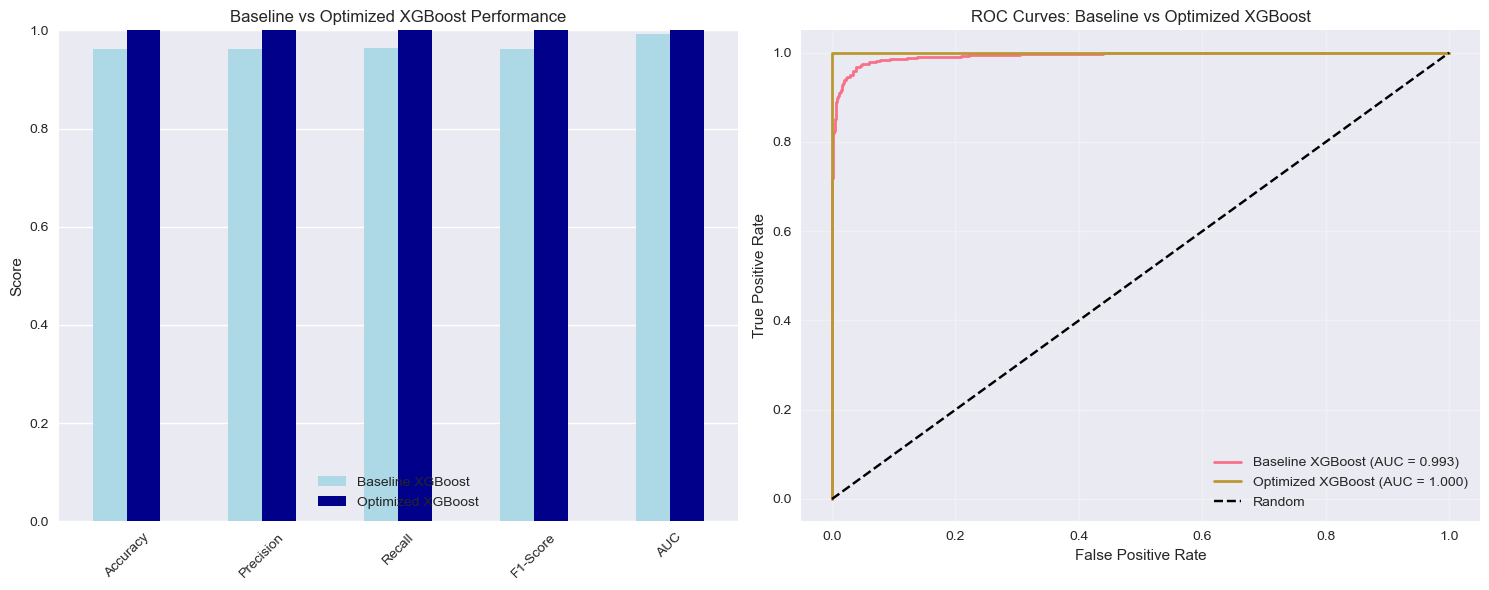

In [58]:
print("\nBaseline vs Optimized XGBoost Comparison")

# Prepare comparison data
comparison_data = {
    'Baseline XGBoost': [baseline_accuracy, baseline_precision, baseline_recall, baseline_f1, baseline_auc],
    'Optimized XGBoost': [tuned_accuracy, tuned_precision, tuned_recall, tuned_f1, tuned_auc]
}
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC']

comparison_df = pd.DataFrame(comparison_data, index=metrics)

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Performance comparison
comparison_df.plot(kind='bar', ax=axes[0], color=['lightblue', 'darkblue'])
axes[0].set_title('Baseline vs Optimized XGBoost Performance')
axes[0].set_ylabel('Score')
axes[0].legend()
axes[0].tick_params(axis='x', rotation=45)
axes[0].set_ylim(0, 1)

# ROC curves comparison
fpr_baseline, tpr_baseline, _ = roc_curve(y_val, y_val_pred_proba_baseline)
fpr_tuned, tpr_tuned, _ = roc_curve(y_val, y_val_pred_proba_tuned)

axes[1].plot(fpr_baseline, tpr_baseline, label=f'Baseline XGBoost (AUC = {baseline_auc:.3f})', linewidth=2)
axes[1].plot(fpr_tuned, tpr_tuned, label=f'Optimized XGBoost (AUC = {tuned_auc:.3f})', linewidth=2)
axes[1].plot([0, 1], [0, 1], 'k--', label='Random')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curves: Baseline vs Optimized XGBoost')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Model Test

In [60]:
# Final model evaluation on test set
print("Final XGBoost Model Evaluation on Test Set")

# Use the optimized XGBoost model
y_test_pred = final_model.predict(X_test)
y_test_pred_proba = final_model.predict_proba(X_test)[:, 1]

# Calculate final metrics
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
test_auc = roc_auc_score(y_test, y_test_pred_proba)

print(f"\nFINAL TEST SET PERFORMANCE (Optimized XGBoost):")
print(f"Accuracy:  {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f} (False Positive Rate: {1-test_precision:.4f})")
print(f"Recall:    {test_recall:.4f} (False Negative Rate: {1-test_recall:.4f})")
print(f"F1-Score:  {test_f1:.4f}")
print(f"AUC-ROC:   {test_auc:.4f}")

Final XGBoost Model Evaluation on Test Set

FINAL TEST SET PERFORMANCE (Optimized XGBoost):
Accuracy:  0.9681
Precision: 0.9628 (False Positive Rate: 0.0372)
Recall:    0.9738 (False Negative Rate: 0.0262)
F1-Score:  0.9682
AUC-ROC:   0.9936


In [61]:
# Business impact analysis
total_phishing = (y_test == 1).sum()
total_legitimate = (y_test == 0).sum()
false_negatives = ((y_test == 1) & (y_test_pred == 0)).sum()
false_positives = ((y_test == 0) & (y_test_pred == 1)).sum()

print(f"\nBusiness Impact Analysis:")
print(f"Total phishing URLs in test set: {total_phishing}")
print(f"Phishing URLs missed (False Negatives): {false_negatives} ({false_negatives/total_phishing*100:.1f}%)")
print(f"Legitimate URLs blocked (False Positives): {false_positives} ({false_positives/total_legitimate*100:.1f}%)")


Business Impact Analysis:
Total phishing URLs in test set: 1143
Phishing URLs missed (False Negatives): 30 (2.6%)
Legitimate URLs blocked (False Positives): 43 (3.8%)


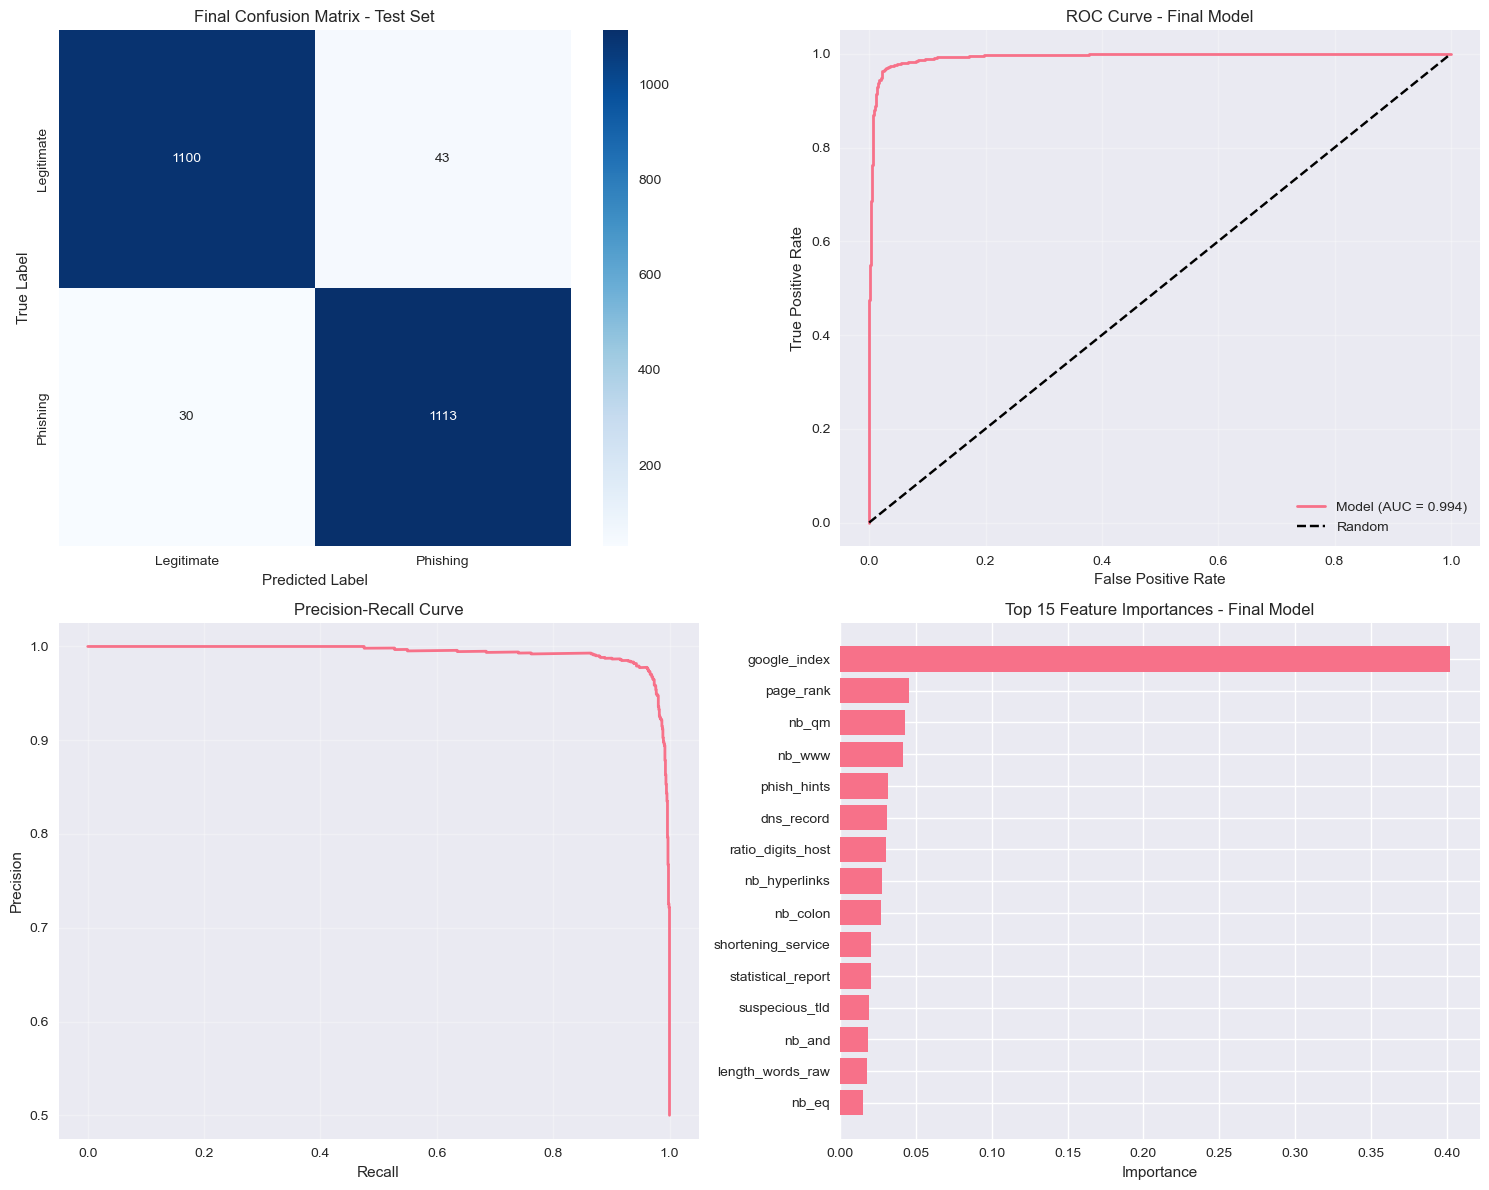

In [62]:
# Detailed evaluation visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Confusion Matrix
test_cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(test_cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Legitimate', 'Phishing'],
            yticklabels=['Legitimate', 'Phishing'], ax=axes[0,0])
axes[0,0].set_title('Final Confusion Matrix - Test Set')
axes[0,0].set_ylabel('True Label')
axes[0,0].set_xlabel('Predicted Label')

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_proba)
axes[0,1].plot(fpr, tpr, label=f'Model (AUC = {test_auc:.3f})', linewidth=2)
axes[0,1].plot([0, 1], [0, 1], 'k--', label='Random')
axes[0,1].set_xlabel('False Positive Rate')
axes[0,1].set_ylabel('True Positive Rate')
axes[0,1].set_title('ROC Curve - Final Model')
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# Precision-Recall Curve
from sklearn.metrics import precision_recall_curve
precision_curve, recall_curve, pr_thresholds = precision_recall_curve(y_test, y_test_pred_proba)
axes[1,0].plot(recall_curve, precision_curve, linewidth=2)
axes[1,0].set_xlabel('Recall')
axes[1,0].set_ylabel('Precision')
axes[1,0].set_title('Precision-Recall Curve')
axes[1,0].grid(True, alpha=0.3)

# Feature Importance
if hasattr(final_model, 'feature_importances_'):
    importance_final = pd.DataFrame({
        'feature': X.columns,
        'importance': final_model.feature_importances_
    }).sort_values('importance', ascending=False).head(15)
    
    axes[1,1].barh(range(len(importance_final)), importance_final['importance'])
    axes[1,1].set_yticks(range(len(importance_final)))
    axes[1,1].set_yticklabels(importance_final['feature'])
    axes[1,1].set_title('Top 15 Feature Importances - Final Model')
    axes[1,1].set_xlabel('Importance')
    axes[1,1].invert_yaxis()

plt.tight_layout()
plt.show()

In [63]:
# Classification Report
print(f"\nDetailed Classification Report:")
print(classification_report(y_test, y_test_pred, target_names=['Legitimate', 'Phishing']))


Detailed Classification Report:
              precision    recall  f1-score   support

  Legitimate       0.97      0.96      0.97      1143
    Phishing       0.96      0.97      0.97      1143

    accuracy                           0.97      2286
   macro avg       0.97      0.97      0.97      2286
weighted avg       0.97      0.97      0.97      2286



# 6. Model Deployment  

In this section, we outline the strategy for deploying the machine learning model into a production environment.

### AWS Deployment Architecture

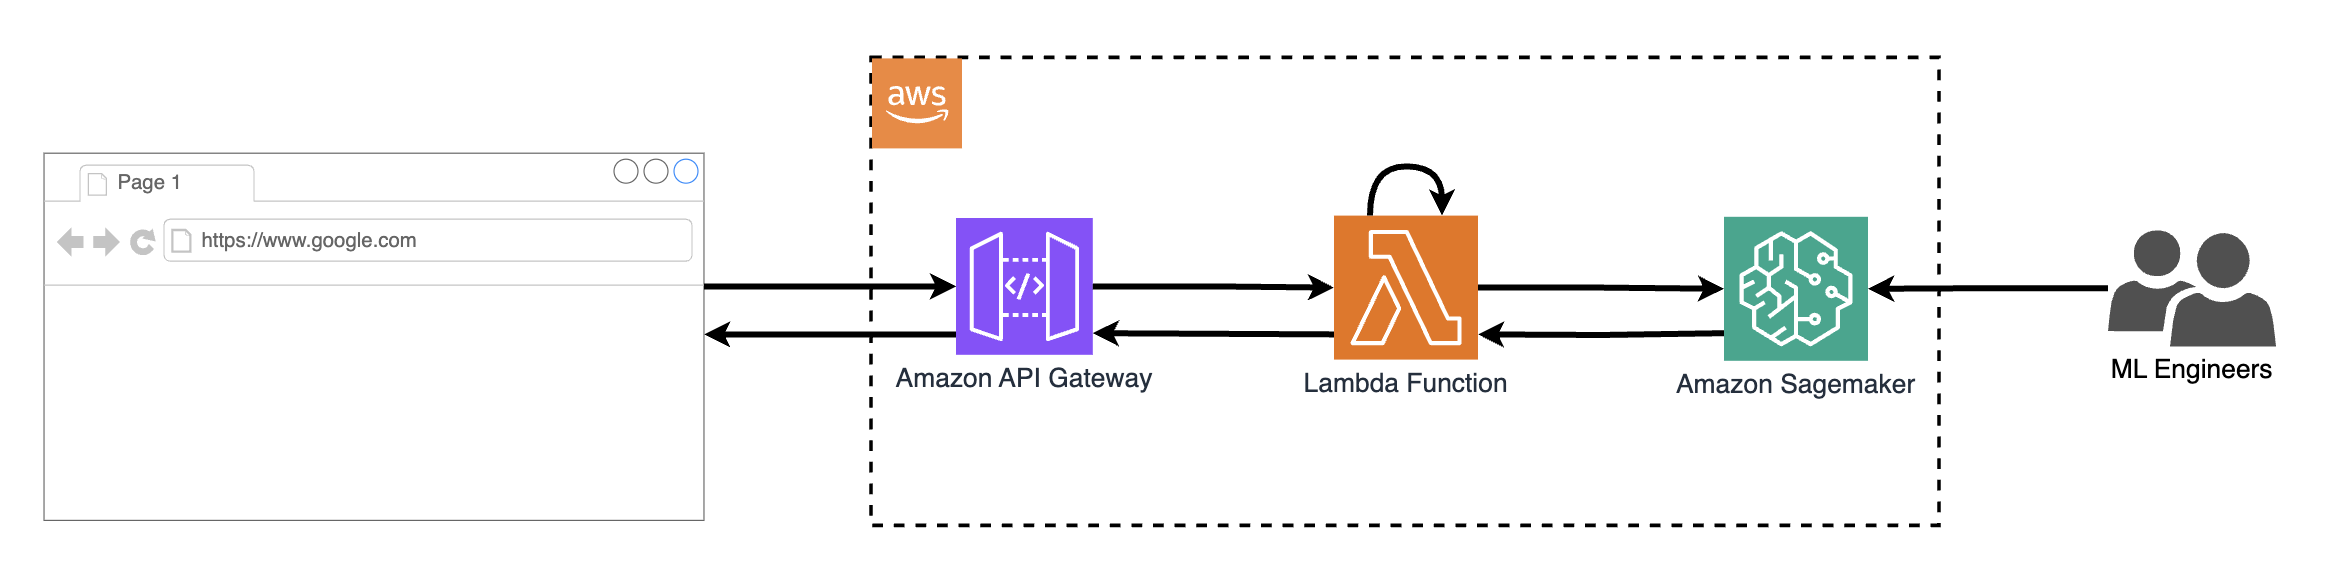

In [66]:
from IPython.display import Image
Image(filename='images/deployment.png')

This system leverages AWS services to deploy a real-time phishing detection model accessible through a web browser. The architecture is designed for scalability, low latency, and ease of integration with browser extensions or client-side applications.

As illustrated above, the process works as follows:
1. Web Browser: A browser extension or client sends a URL to be classified via a secure HTTP request.
2. API Gateway: Serves as the public-facing endpoint, handling and routing the HTTP request.
3. AWS Lambda Function: Acts as the core logic layer parsesing the incoming URL and applying a deterministic feature extraction algorithm to generate the same 50 features used in model training. After the features are extracted, the labda function forwards the feature vector to the SageMaker endpoint for prediction.
4. SageMaker Endpoint: Hosts the pre-trained machine learning model and returns a classification label (phishing or legitimate).
5. AWS Lambda Function: Sends the prediction result back through the API Gateway to the browser.
6. ML Engineering Operations: A team of ML engineers continuously monitors model performance and retrains the model using updated data.

This serverless design ensures high scalability, minimal operational overhead, and efficient cost management. The modular setup also allows for rapid updates to the model without disrupting the API structure.

# 7. Conclusion

In this project, we built a machine learning pipeline to detect phishing websites by analyzing features extracted from URLs. After selecting the top 50 features most correlated with the target variable, we trained and evaluated multiple traditional classification models. Among them, the XGBoost classifier outperformed all others, achieving the highest accuracy and demonstrating strong predictive capability. This model provides a reliable foundation for real-time phishing detection solutions, such as browser extensions or security APIs, aimed at improving user safety on the web.

----------------
$^{1}$ Hannousse, A., & Yahiouche, S. (2021). Web page phishing detection (Version 3) [Data set]. Mendeley Data. https://doi.org/10.17632/c2gw7fy2j4.3